In [15]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ezdxf
import os
import json
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_mask_from_annotation(image_path, annotation_path):
    with open(annotation_path) as f:
        data = json.load(f)
    
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    
    mask = np.zeros((height, width), dtype=np.uint8)
    
    for shape in data['shapes']:
        points = shape['points']
        points = np.array(points, dtype=np.int32)
        cv2.fillPoly(mask, [points], color=1)
    
    return mask

def load_and_preprocess_data(image_path, annotation_path, target_size=(256, 256)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = create_mask_from_annotation(image_path, annotation_path)
    
    image = cv2.resize(image, target_size)
    mask = cv2.resize(mask, target_size)
    
    image = image.astype('float32') / 255.0
    mask = mask.astype('float32')
    
    return image, mask

def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # Encoder (downsampling)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bridge
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    
    # Decoder (upsampling)
    up4 = UpSampling2D(size=(2, 2))(conv3)
    up4 = concatenate([up4, conv2])
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    
    up5 = UpSampling2D(size=(2, 2))(conv4)
    up5 = concatenate([up5, conv1])
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [19]:

import os


image_path = r"C:\Users\HP\Downloads\ax\a1.jpg"
annotation_path = r"C:\Users\HP\Downloads\data\a1.json"
if os.path.exists(annotation_path):
    print(f"Le fichier existe à {annotation_path}")
else:
    print(f"Le fichier n'existe pas à {annotation_path}")

image, mask = load_and_preprocess_data(image_path, annotation_path)

# Ajout d'une dimension de batch et de canal
X = np.expand_dims(image, axis=(0, -1))
Y = np.expand_dims(mask, axis=(0, -1))

# Configuration de l'augmentation de données
data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Initialisation des générateurs
seed = 1
image_generator = image_datagen.flow(X, seed=seed)
mask_generator = mask_datagen.flow(Y, seed=seed)

# Combinaison des générateurs
train_generator = zip(image_generator, mask_generator)

print("Forme de l'image d'entrée :", X.shape)
print("Forme du masque d'entrée :", Y.shape)

Le fichier existe à C:\Users\HP\Downloads\data\a1.json
Forme de l'image d'entrée : (1, 256, 256, 1)
Forme du masque d'entrée : (1, 256, 256, 1)


Epoch 1/50
100/100 [==============================] - 79s 769ms/step - loss: 0.2460 - accuracy: 0.9241
Epoch 2/50
100/100 [==============================] - 86s 857ms/step - loss: 0.1475 - accuracy: 0.9532
Epoch 3/50
100/100 [==============================] - 84s 843ms/step - loss: 0.1415 - accuracy: 0.9532
Epoch 4/50
100/100 [==============================] - 78s 776ms/step - loss: 0.1370 - accuracy: 0.9539
Epoch 5/50
100/100 [==============================] - 82s 824ms/step - loss: 0.1326 - accuracy: 0.9532
Epoch 6/50
100/100 [==============================] - 86s 864ms/step - loss: 0.1207 - accuracy: 0.9526
Epoch 7/50
100/100 [==============================] - 84s 845ms/step - loss: 0.1064 - accuracy: 0.9530
Epoch 8/50
100/100 [==============================] - 88s 879ms/step - loss: 0.0944 - accuracy: 0.9539
Epoch 9/50
100/100 [==============================] - 86s 864ms/step - loss: 0.0797 - accuracy: 0.9578
Epoch 10/50
100/100 [==============================] - 86s 859ms/step - l

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


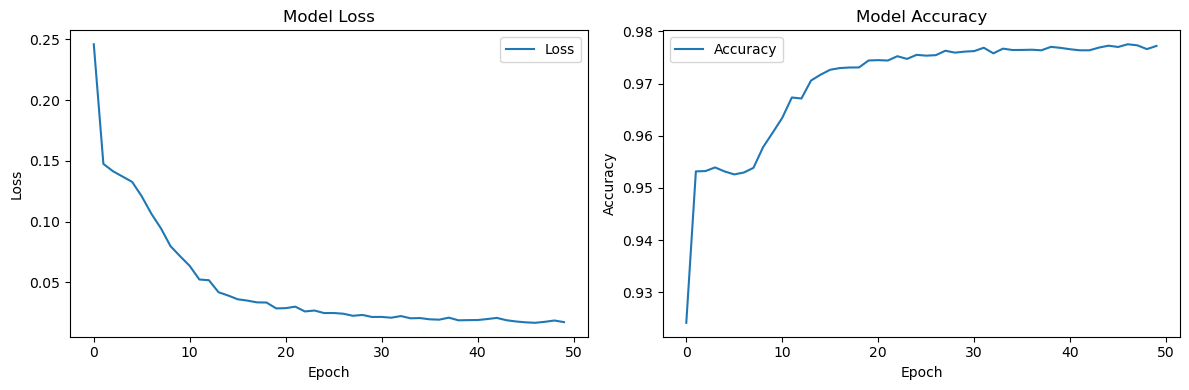

In [20]:
model = unet()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Entraînement avec augmentation de données
history = model.fit(train_generator,
                    steps_per_epoch=100,  # Nombre d'étapes par époque
                    epochs=50,
                    verbose=1)

# Sauvegarde du modèle
model.save(r'C:\Users\HP\Downloads\improved_unet_model.h5')

# Affichage de l'historique d'entraînement
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 1s 1s/step
Fichier DXF sauvegardé : C:\Users\HP\Downloads\output_unet.dxf


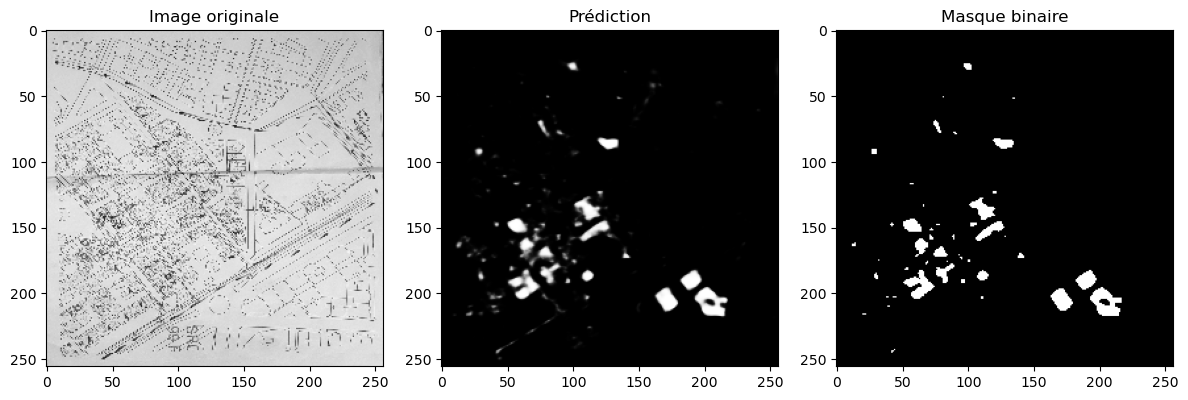

In [21]:
def detect_contours(image):
    return cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

def save_dxf(contours, output_path):
    doc = ezdxf.new('R2010')
    msp = doc.modelspace()
    
    for contour in contours:
        points = contour.squeeze().tolist()
        if len(points) > 1:
            if isinstance(points[0], list):
                points = [(p[0], p[1]) for p in points]
            else:
                points = [(points[i], points[i+1]) for i in range(0, len(points), 2)]
            msp.add_lwpolyline(points)
    
    doc.saveas(output_path)
    print(f"Fichier DXF sauvegardé : {output_path}")

# Test sur l'image d'entraînement
test_image = X[0]
prediction = model.predict(np.expand_dims(test_image, axis=0))[0,:,:,0]
binary_mask = (prediction > 0.5).astype(np.uint8)

contours, _ = detect_contours(binary_mask)

# Sauvegarder en DXF
save_dxf(contours, r'C:\Users\HP\Downloads\output_unet.dxf')

# Afficher le résultat
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(test_image[:,:,0], cmap='gray')
plt.title('Image originale')
plt.subplot(132)
plt.imshow(prediction, cmap='gray')
plt.title('Prédiction')
plt.subplot(133)
plt.imshow(binary_mask, cmap='gray')
plt.title('Masque binaire')
plt.tight_layout()
plt.show()